In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as sc
import scipy
import sys
sys.path.insert(0, 'C:\Users\localadmin.TUD278183\Desktop\GitProjects\pyWEST\AutomatedCall')
from Parallel_WESTRunningWrapper import ModelInstances
import timeit

plt.style.use('ggplot')
%matplotlib inline



## Model Calibration Example


In [2]:
# Setting up model
ModelInstance = ModelInstances(['Model_dummy_2'], modelPath = "C:\Users\localadmin.TUD278183\Desktop\GitProjects\pyWEST")

def ReadOutput(fileouputname, ModelNAME, TimeWindowStart = None, variable = None):
    Output = pd.read_csv('C:\Users\localadmin.TUD278183\Desktop\GitProjects\pyWEST\\' + ModelNAME +'\\' + fileouputname , sep = '\t', skiprows=[1], index_col=[0])
    if TimeWindowStart is not None:
        
        Ind = Output.index.tolist()
        TimefreqOutput = int(round((Ind[1]-Ind[0])*3600*24)) # frequency of communication output in seconds. NOTE: The communication in the WEST output should be a fraction of day and interpolated (with as many decimals as possible to avoid problems with drifting of the timeseries) e.g. hourly should be: 0.041666666666666664, avoid rounding to 0.041667          
        TimeEnlapsed = pd.date_range(pd.to_datetime(TimeWindowStart) ,periods = len(Output), freq = '{}S'.format(TimefreqOutput))
        Output.set_index(TimeEnlapsed, inplace = True)
    
    if variable is None:
        return Output
    else: 
        return Output[variable]

Simulation time : 3.33663510452 seconds
{'n': 0.08, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 10}


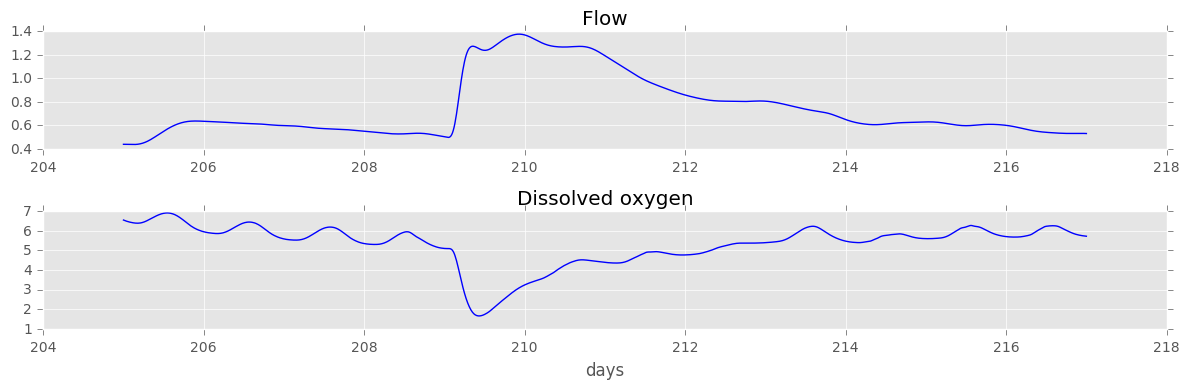

In [3]:
# Parameter definition

Timelist = {'StartTime':205,'StopTime':217} 
Parameterlist = {'W_b': 10, 'n':0.08, 'VKL': 2, 'Kd1': 0.4, 'Kd2':0.3}   

# Model Run
start_timer = timeit.default_timer()   
ModelInstance.model_run(Parameterlist, Timelist)

Output_Q = ReadOutput('Model_dummy_1.River_quantity_Dynamic.Simul.out.txt', 'Model_dummy_2', variable = '.River_5.Q')
Output_DO = ReadOutput('Model_dummy_1.Dynamic_water_quantity.Simul.1.out.txt', 'Model_dummy_2', variable = '.River_5.DO')

# Plot output and simulation time
print 'Simulation time : {} seconds'.format(timeit.default_timer() - start_timer)
print Parameterlist

fig, ax = plt.subplots(2,1, figsize=(12,4))
ax[0].plot(Output_Q, 'b')
ax[0].set_title('Flow')
ax[1].plot(Output_DO, 'b')
ax[1].set_title('Dissolved oxygen')
ax[1].set_xlabel('days')
plt.tight_layout()

In [5]:
0.2*0.2

0.04000000000000001

In [6]:
0.2**0.5

0.4472135954999579

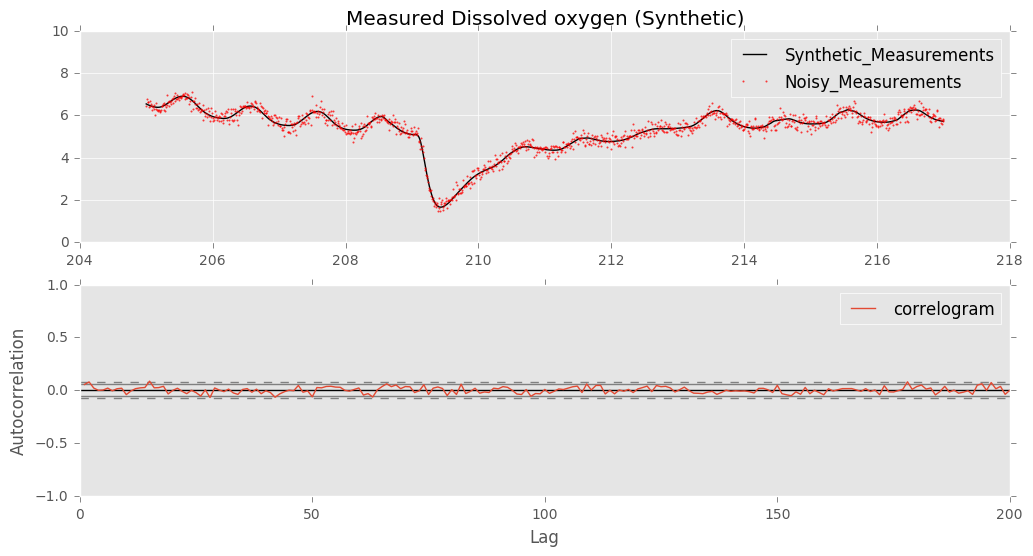

In [10]:
# Generate measurement scheme:
import math
np.random.seed(132)

# Generate autocorrelated homoscedastic error with exponential decay.
def AutocorrelatedError(mu, variance, correlationlength, samplesize):
    N = samplesize
    mean = np.zeros(N) + mu
    cov = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            x = abs(i-j) #time distance in timesteps
            cov[i,j] = float(variance) * math.exp(-x/(float(correlationlength)))
    return np.random.multivariate_normal(mean, cov), cov

#sampleError_iid, cov = AutocorrelatedError(0, 0.2, 0.000001, len(Output_DO))
sampleError_iid = np.random.normal(0,0.2,len(Output_DO))
Measured_DO_iid = Output_DO + sampleError_iid
Measured_Q_iid = Output_Q

#plotting measurements and noise added
fig, ax = plt.subplots(2,1, figsize = (12, 6))

ax[0].plot(Output_DO, 'k', label =  'Synthetic_Measurements')
ax[0].plot(Measured_DO_iid, 'r.', alpha = 0.6, ms = 2 , label =  'Noisy_Measurements')
ax[0].set_ylim((0,10))
ax[0].set_title('Measured Dissolved oxygen (Synthetic)')
#correlation plot
pd.tools.plotting.autocorrelation_plot(sampleError_iid, ax[1], label = 'correlogram')
ax[1].set_ylim((-1,1))
ax[1].set_xlim((0,200))

for axi in ax:
    axi.legend()

##### Using NS as objective function

In [21]:
#Define objective function NS

def NS(s,o):
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    return 1 - sum((s-o)**2)/sum((o-np.mean(o))**2)

iters = 0 
def ObjectiveFunction(u):
    global iters
    
    iters +=1
    
    Timelist = {'StartTime':205,'StopTime':217} 
    Parameterlist = {'W_b': u[0], 'n':u[1], 'VKL': 2, 'Kd1': 0.4, 'Kd2':0.3}   

    # Model Run
    start_timer = timeit.default_timer()   
    ModelInstance.model_run(Parameterlist, Timelist)

    Output_Q = ReadOutput('Model_dummy_1.River_quantity_Dynamic.Simul.out.txt', 'Model_dummy_2', variable = '.River_5.Q')
    Output_DO = ReadOutput('Model_dummy_1.Dynamic_water_quantity.Simul.1.out.txt', 'Model_dummy_2', variable = '.River_5.DO')    
    
    out = - NS(Output_Q, Measured_Q_iid)
    print Parameterlist
    print out
    return out


# minimize

u = [8, 0.03] #initial
bnds = ((2, 15), (0.01, 2))

res = scipy.optimize.minimize(ObjectiveFunction, u, method='nelder-mead', bounds = bnds, options={'xtol': 1e-2, 'disp': True, 'maxfev': 10})

{'n': 0.029999999999999999, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.0}
-0.637147103126
{'n': 0.029999999999999999, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.4000000000000004}
-0.653231479112
{'n': 0.0315, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.0}
-0.668598419575
{'n': 0.0315, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.3999999999999986}
-0.68390004725
{'n': 0.032250000000000001, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.5999999999999979}
-0.705312377194
{'n': 0.033750000000000002, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.1999999999999975}
-0.717904773718
{'n': 0.035625000000000004, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.0999999999999979}
-0.745167957901
{'n': 0.036375000000000005, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.6999999999999957}
-0.775471474981
{'n': 0.0388125, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 9.0499999999999936}
-0.817537156153
{'n': 0.042187500000000003, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.5499999999999936}
-0.842413880363
{'n': 0.047156250000

##### Using Max Likelihood gaussian iid

In [29]:
def ObjectiveFunction(u):
    global iters
    
    iters +=1
    
    Timelist = {'StartTime':205,'StopTime':217} 
    Parameterlist = {'W_b': u[0], 'n':u[1], 'VKL': 2, 'Kd1': 0.4, 'Kd2':0.3}   

    # Model Run
    start_timer = timeit.default_timer()   
    ModelInstance.model_run(Parameterlist, Timelist)

    Output_Q = ReadOutput('Model_dummy_1.River_quantity_Dynamic.Simul.out.txt', 'Model_dummy_2', variable = '.River_5.Q')
    Output_DO = ReadOutput('Model_dummy_1.Dynamic_water_quantity.Simul.1.out.txt', 'Model_dummy_2', variable = '.River_5.DO')    

    
    cov = np.eye(len(Output_Q)) * (u[2]**2)    
    try:
        loglike = sc.multivariate_normal.logpdf(Output_Q, mean=Measured_Q_iid, cov=cov)
    except:
        loglike = -np.inf    

    print '{} {}'.format(Parameterlist, u[2])
    print u[2]
    print -loglike
    return -loglike

u = [8, 0.03, 0.1] #initial
bnds = ((2, 15), (0.01, 2))

res = scipy.optimize.minimize(ObjectiveFunction, u, method='nelder-mead', bounds = bnds, options={'xtol': 1e-2, 'disp': True, 'maxfev': 1000})

{'n': 0.029999999999999999, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.0} 0.1
0.1
-174.291452317
{'n': 0.029999999999999999, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.4000000000000004} 0.1
0.1
-240.288584871
{'n': 0.0315, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.0} 0.1
0.1
-303.341948428
{'n': 0.029999999999999999, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.0} 0.105
0.105
-254.064995199
{'n': 0.031, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.2666666666666657} 0.103333333333
0.103333333333
-351.58352533
{'n': 0.0315, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.3999999999999986} 0.105
0.105
-428.065783747
{'n': 0.032000000000000001, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 7.8666666666666654} 0.106666666667
0.106666666667
-407.072741509
{'n': 0.03333333333333334, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.1777777777777771} 0.102777777778
0.102777777778
-503.112955421
{'n': 0.035000000000000003, 'VKL': 2, 'Kd1': 0.4, 'Kd2': 0.3, 'W_b': 8.2666666666666657} 0.101666666667
0.101666666667
-